In [1]:
import tensorflow as tf
import numpy as np
import scipy.io
import time
from pyDOE import lhs
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata


d:\anaconda3\envs\tf\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


#### Data Preprocessing

In [2]:

N_u = 100                    # number of data points
N_f = 10000                  # number of points where the differential equation must be satisfied

data = scipy.io.loadmat('burgers_equation.mat')                     # load Burgers equation dataset from matlab file
t = data['t'].flatten()[:, None].astype('float32')                  # time discretization points
x = data['x'].flatten()[:, None].astype('float32')                  # spatial(x) discretization points
exact_sol = np.real(data['usol']).T.astype('float32')               # exact solution

X, T = np.meshgrid(x, t)                                            # create a mesh from data coordinates x,t


In [3]:
X_domain = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))  # includes spatial in col 1 and then time coordinates col 2
u_domain = exact_sol.flatten()[:, None]

In [4]:
# Domain bounds
lb = X_domain.min(0)
ub = X_domain.max(0)

In [5]:
xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T)) # I.C.
uu1 = exact_sol[0:1, :].T                   # u solution for the selected points at diff. conditions as mentioned
xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))  # L.B.C. i.e. at x = -1
uu2 = exact_sol[:, 0:1]
xx3 = np.hstack((X[:, -1:], T[:, -1:])) # R.B.C. i.e. at x = +1
uu3 = exact_sol[:, -1:]

X_u_train = np.vstack([xx1, xx2, xx3])      # Total # of final coordinates (x,t) for the training points
X_f_train = lb + (ub - lb) * lhs(2, N_f)    # coordinates (x,t) of the points to satisfy the differential equation
X_f_train = tf.convert_to_tensor(np.vstack((X_f_train, X_u_train)).astype('float32'))
u_train = np.vstack([uu1, uu2, uu3])        # the solution of the training points

# reducing our dataset by randomly selecting N_u points 
index = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = tf.convert_to_tensor(X_u_train[index, :].astype('float32'))
u_train = tf.convert_to_tensor(u_train[index, :].astype('float32'))

# splittling spatial and time coordinates
x_u = X_u_train[:, 0:1]  # column 0
t_u = X_u_train[:, 1:2]  # column 1
x_f = X_f_train[:, 0:1]  # column 0 
t_f = X_f_train[:, 1:2]  # column 1 

#### Creating Custom Model

In [6]:
# custom model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
class CustomModel(Model):
    
    def __init__(self, **kwargs):
        super(CustomModel, self).__init__(**kwargs)
        self.dense1 = Dense(20, activation='tanh')
        self.dense2 = Dense(20, activation='tanh')
        self.dense3 = Dense(20, activation='tanh')
        self.dense4 = Dense(20, activation='tanh')
        self.dense5 = Dense(20, activation='tanh')
        self.dense6 = Dense(20, activation='tanh')
        self.dense7 = Dense(20, activation='tanh')
        self.dense8 = Dense(20, activation='tanh')
        self.dense9 = Dense(1, activation=None)
        
    def call(self, x, t):
        z = self.dense1(tf.concat([x, t], 1))
        z = self.dense2(z)
        z = self.dense3(z)
        z = self.dense4(z)
        z = self.dense5(z)
        z = self.dense6(z)
        z = self.dense7(z)
        z = self.dense8(z)
        return self.dense9(z)
    
model = CustomModel()


#### Custom Loss Fuction
This includes MeanSquareError in the u(t,x) and residual function value(f)

In [7]:
def loss(model, u_train, x_u, t_u, x_f, t_f, training):
    u_pred = model(x_u,t_u, training=training)
    f_pred = residual_loss_fn(model, x_f, t_f)  # f_pred is the residual loss
    return tf.reduce_sum(tf.square(u_train - u_pred)) / u_pred.shape[0] + \
             tf.reduce_sum(tf.square(f_pred)) / f_pred.shape[0]

In [8]:
# create a custom loss function
def residual_loss_fn(model, x, t):
    with tf.GradientTape() as gtp1:
        gtp1.watch(x)
        with tf.GradientTape(persistent=True) as gtp2:
            gtp2.watch(x)
            gtp2.watch(t)
            u = model(x, t)
        du_dt = gtp2.gradient(u, t)
        du_dx = gtp2.gradient(u, x)
    du2_dx2 = gtp1.gradient(du_dx, x)
    coefficient = 0.01 / np.pi
    f = du_dt + u * du_dx - coefficient * du2_dx2   # burgers equation's residual
    del gtp2
    return f


#### Custom Training 
Adam optimizer is used for training. Number of epochs required for training can be changed for optimization.

In [9]:

def grad(model, u_train, x_u, t_u, x_f, t_f):
    with tf.GradientTape() as tape:
        loss_value = loss(model, u_train, x_u, t_u, x_f, t_f, training = True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

def predict(model, X_test):
    X_test = tf.convert_to_tensor(X_test) # converting to tensor for use as tensor
    u_test = model(X_test[:, 0:1], X_test[:, 1:2])
    f_test = residual_loss_fn(model, X_test[:, 0:1], X_test[:, 1:2])
    return u_test, f_test

# selecting the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

############Custom Training################ 

start_time = time.time()
train_loss_results = []
model = CustomModel()

num_epochs = 6000 # Set number of epochs required for training

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

# Optimize the model
    loss_value, grads = grad(model, u_train, x_u, t_u, x_f, t_f)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

# Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
# Compare predicted label to actual label
# training=True is needed only if there are layers with different
# behavior during training versus inference (e.g. Dropout).
# End epoch
    train_loss_results.append(epoch_loss_avg.result())

    if epoch % 50 == 0:
        print("Epoch {:04d}: Loss: {:.6f}".format(epoch,epoch_loss_avg.result()))
elapsed_time = time.time() - start_time

u_pred, f_pred = predict(model, X_domain) # predictions for all points in the domain
error_u = np.linalg.norm(u_domain - u_pred) / np.linalg.norm(u_domain)
print('Training time:', elapsed_time)
print('Error u: %e' % (error_u))



Epoch 0000: Loss: 0.247093
Epoch 0050: Loss: 0.135473
Epoch 0100: Loss: 0.102100
Epoch 0150: Loss: 0.090075
Epoch 0200: Loss: 0.081338
Epoch 0250: Loss: 0.072219
Epoch 0300: Loss: 0.070140
Epoch 0350: Loss: 0.063465
Epoch 0400: Loss: 0.059499
Epoch 0450: Loss: 0.055483
Epoch 0500: Loss: 0.052086
Epoch 0550: Loss: 0.049619
Epoch 0600: Loss: 0.046986
Epoch 0650: Loss: 0.044810
Epoch 0700: Loss: 0.043061
Epoch 0750: Loss: 0.044559
Epoch 0800: Loss: 0.040000
Epoch 0850: Loss: 0.043513
Epoch 0900: Loss: 0.036803
Epoch 0950: Loss: 0.035990
Epoch 1000: Loss: 0.038903
Epoch 1050: Loss: 0.033233
Epoch 1100: Loss: 0.032488
Epoch 1150: Loss: 0.033157
Epoch 1200: Loss: 0.028821
Epoch 1250: Loss: 0.036888
Epoch 1300: Loss: 0.027659
Epoch 1350: Loss: 0.025263
Epoch 1400: Loss: 0.023166
Epoch 1450: Loss: 0.028849
Epoch 1500: Loss: 0.021431
Epoch 1550: Loss: 0.019204
Epoch 1600: Loss: 0.018465
Epoch 1650: Loss: 0.015552
Epoch 1700: Loss: 0.013469
Epoch 1750: Loss: 0.035622
Epoch 1800: Loss: 0.027553
E

#### Plotting the results

In [10]:
u_pred = u_pred.numpy() # Recovering as python object
U_pred = griddata(X_domain, u_pred.flatten(), (X,T), method = 'cubic')
Error  = np.abs( exact_sol - U_pred)

Text(0.5, 1.0, '$t = 0.75$')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


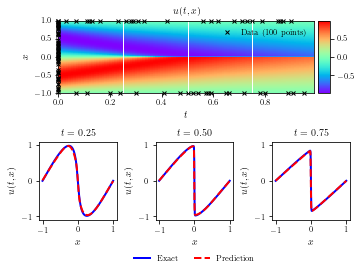

In [11]:
############################# Plotting ###############################

fig, ax = newfig(1.0, 1.1)
ax.axis('off')

##### Row 0: u(t,x) #####    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)

#### Row 1: u(t,x) slices #####    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,exact_sol[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,exact_sol[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,exact_sol[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)
  